In [1]:
import torch

## Load the mesh

We use Trimesh to load, check and format the mesh. It is represented by its vertices, faces and colors. We place ourselves in the simplest configuration, where all the faces are triangular and the colors are defined for each vertex. The mesh must also be manifold and of genus 0.

With V the number of vertices and F the number of faces,
- The Verts array contains the XYZ coordinates for each vertex. Floats, shape \[V, 3\]
- The Faces array contains the indices of the vertices connected in the original Verts array. Indexes are ordered counter-clockwise facing outward. Int64, shape \[F, 3\]
- The Colors array contains the RGB colors of each vertex, in the same order as the Verts array. Colors range from 0 to 1. Float, shape \[V, 3\]

All vectors are Pytorch vectors, allowing the GPU to be used to do the calculations. You can however use the CPU by changing the device parameter, which is almost the same as using numpy

Note: For closed triangular meshes of genus 0, F = 2(V-2) according to the Euler‐Poincaré formula

In [2]:
import trimesh

mesh = trimesh.load_mesh("data/spot_color.obj", "obj", maintain_order=True, process=False)
mesh.visual = mesh.visual.to_color()  # Convert UV mapping to vertex-wise colors

assert mesh.is_watertight  # Watertight (or a closed manifold mesh)
assert mesh.euler_number == 2  # Genus 0 (or topology of a sphere)

device = torch.device('cpu')
verts = torch.from_numpy(mesh.vertices).to(device=device).float()
faces = torch.from_numpy(mesh.faces).to(device=device).long()
colors = torch.from_numpy(mesh.visual.vertex_colors).to(device=device)
colors = colors[..., :3].float() / 255.

Pyvista allows us to render meshes in an interactive window. Let's see what our initial mesh looks like. We chose to use colors by vertices instead of UV mapping, which causes some color distortion.

In [3]:
import pyvista
import numpy as np


def show_mesh(vertices, faces, vertices_colors=None):
    vertices = vertices.detach().cpu().numpy()
    faces = faces.detach().cpu().numpy()
    
    faces = np.concatenate([np.ones([faces.shape[0], 1], dtype=faces.dtype)*3, faces], axis=1)
    mesh = pyvista.PolyData(vertices, faces)
    has_colors = vertices_colors is not None
    if has_colors:
        vertices_colors = vertices_colors.detach().cpu().numpy()
        if vertices_colors.dtype == np.float32:
            vertices_colors = np.clip(vertices_colors * 255, 0, 255).astype(np.uint8)
    plotter = pyvista.Plotter(notebook=True)
    plotter.add_mesh(mesh, scalars=vertices_colors, rgb=has_colors)
    plotter.camera_position = 'xy'
    plotter.camera.elevation = 10.
    plotter.camera.azimuth = 210.
    plotter.show(jupyter_backend='pythreejs', window_size=[500, 500])


show_mesh(verts, faces, vertices_colors=colors)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='#fefefe', intensity=0.25, position=(0.0, 0…

## From mesh to spherical harmonics

The spherical parametrization is obtained by the Mean Curvature Flow. It is conformal (or angle-preserving), and not authalic (or area-preserving), which means that certain complex parts such as the head are very compressed on the sphere. To reconstruct the mesh, it will be necessary to take this distortion into account.

In preparation for what follows, the cmcf function returns the projection on the sphere ('proj') but also the initial curvature density and area distortion vectors ('feat').

The execution time depends on the size of the step, but if the mesh does not converge, the step_size must be reduced (and max_iters must be big enough)

In [4]:
from mesh2sh.sphere_parametrization import cmcf
from mesh2sh.geometry import spherical_to_cartesian

proj, feat = cmcf(verts, faces, max_iters=100, step_size=0.05)


sphere_verts = torch.stack([*spherical_to_cartesian(torch.ones([proj.shape[0]], device=proj.device),
                                                 proj[:, 0], proj[:, 1])], dim=1)
show_mesh(sphere_verts, faces, vertices_colors=colors)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='#fefefe', intensity=0.25, position=(0.0, 0…

There are 6 attributes that we want to encode with spherical harmonics: the vertex density to imitate the original mesh density, the 2 geometric properties given by cMCF (curvature density, area distortion), and the 3 RGB colors.

The approximation is done by interpolating the points on a uniform grid on the sphere, then adapting the coefficients of the spherical harmonics to come as close as possible to the initial function. For the vertex density, the interpolation is done using a kernel density estimation.


sh_coefficients is an array of shape \[6, lmax+1, lmax+1\], lmax being the degree of harmonics.

In [5]:
from mesh2sh.spherical_harmonics import approximate_sh_coefficients, approximate_sh_density

lmax = 300
feature_vector = torch.cat([feat, colors], dim=1)

feature_sph_harm = approximate_sh_coefficients(values=feature_vector, theta=proj[:, 0],
                                               phi=proj[:, 1], lmax=lmax)
density_sph_harm = approximate_sh_density(theta=proj[:, 0], phi=proj[:, 1], lmax=lmax).unsqueeze(0)

sh_coefficients = torch.cat([density_sph_harm, feature_sph_harm], dim=0)

That's it, we have the 2D representation of the surface, which fully describes the initial properties of the model. We can display them as images and see how it looks.

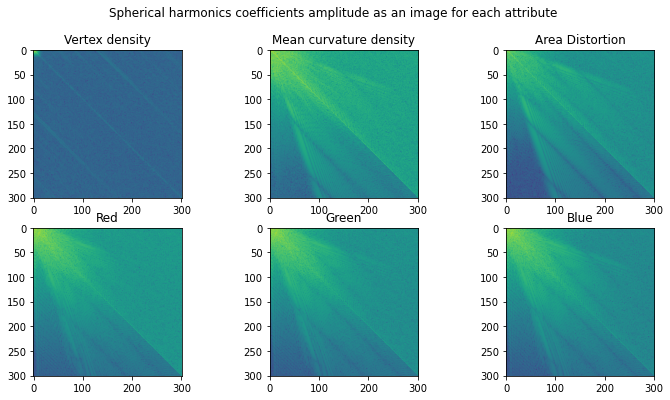

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.suptitle('Spherical harmonics coefficients amplitude as an image for each attribute')
figname = ['Vertex density', 'Mean curvature density', 'Area Distortion', 'Red', 'Green', 'Blue']
for dim in range(sh_coefficients.shape[0]):
    plt.subplot(231+dim)
    plt.imshow(torch.log(sh_coefficients[dim].abs()))
    plt.title(figname[dim])
plt.show()

## From spherical harmonics to mesh

Before proceeding with the reconstruction, a new mesh must be made. 
- Rejection sampling sample a certain number of vertices according to the initial density
- Centroidal Voronoi Tesselation optimizes the position of the vertices and creates the faces to have a clean isotropic mesh

We choose here the number of vertices to be about 5 times higher than the original number of vertices, to be able to represent all the details

In [7]:
from mesh2sh.centroidal_voronoi_tessellation import cvt
from mesh2sh.rejection_sampling import rejection_sphere_sampling
from mesh2sh.spherical_harmonics import pdf_function_from_sh_coeffs

n_verts_reconstruction = 10000

sh_density = sh_coefficients[0]
pdf = pdf_function_from_sh_coeffs(sh_density)
raw_estimated_verts = rejection_sphere_sampling(pdf, n=n_verts_reconstruction, device=device)
est_sph_verts, est_faces = cvt(raw_estimated_verts, pdf, n_iters=5)

/home/gregoire/Bureau/Mesh2SH/mesh2sh/rejection_sampling.py:55: UserWarning: rejection_sphere_sampling is a very basic loop, and can be very slow when the pdf function is slow or has big spikes
  warnings.warn('rejection_sphere_sampling is a very basic loop, and can be very slow when the pdf function is' +


Once the positions of the vertices have been defined, the attributes at these positions are sampled from the spherical harmonic coefficients. The shape is reconstructed using reverse cMCF.

In [8]:
from mesh2sh.sphere_parametrization import reverse_cmcf
from mesh2sh.spherical_harmonics import sample_sh_values


estimated_feature_vector = sample_sh_values(sh_coefficients[1:], theta=est_sph_verts[:, 0], phi=est_sph_verts[:, 1])
est_curv = estimated_feature_vector[:, :2]
est_colors = estimated_feature_vector[:, 2:]

est_verts = reverse_cmcf(sphere_verts=est_sph_verts, features_vector=est_curv, faces=est_faces,
                         n_iters=100, step_size=0.0005)

show_mesh(est_verts, est_faces, vertices_colors=est_colors)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='#fefefe', intensity=0.25, position=(0.0, 0…